# Master Project

This notebook contains the totality of code used for my Master Project.

## Table of contents

- [Data Collection](#part1)
- [Data Cleaning](#part2)
    - [Cleaning and removing non english tweets](#part2sec1)
    - [Remove stopwords](#part2sec2)
    - [Stemming](#part2sec3)
- [Exploratory Analysis](#part3)
    - [Trends](#part3sec1)
    - [Wordclouds](#part3sec2)
    - [Bigrams and Trigrams](#part3sec3)
- [Sentiment Analysis](#part4)
- [Clustering](#part5)
- [Emoji?](#part6)

# Data collection<a id='part1'></a>

I used the `twitterscraper` package with the following query.

```
twitterscraper volkswagen -bd 2015-09-01 -ed 2015-10-15 -o 01_09_2015-15_10_2015.json
```

In [23]:
import re
import json
import random

import numpy as np
import pandas as pd

from PIL import Image

from tqdm import tnrange

from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

from wordcloud import WordCloud

import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import SnowballStemmer
from nltk.tokenize import regexp_tokenize

# Data cleaning<a id='part2'></a>

Let's open the raw data.

In [2]:
%%time

try:
    labels = ['fullname', 'html', 'id', 'likes', 'replies', 'retweets', 'text', 'timestamp', 'url', 'user']
    arr = np.load('data.npy')
    df_full = pd.DataFrame(arr, columns=labels)
except FileNotFoundError:
    with open('01_09_2015-15_10_2015.json', 'r') as file:
        raw = json.load(file)
    df_full = pd.DataFrame(raw)
    np.save('data.npy', df_full.values)

CPU times: user 8.37 s, sys: 12.6 s, total: 21 s
Wall time: 35.7 s


We have collected **914 274** tweets.

In [3]:
print(f'Number of tweets collected: {len(df_full)}')

Number of tweets collected: 914274


A tweet looks like this.

In [4]:
df_full.iloc[1,]

fullname                                       Rhondas Romance
html         <p class="TweetTextSize js-tweet-text tweet-te...
id                                          640675779253280768
likes                                                        0
replies                                                      0
retweets                                                     0
text         I liked a @YouTube video http://youtu.be/pmzZb...
timestamp                                  2015-09-06T23:59:43
url                 /RhosBookReviews/status/640675779253280768
user                                           RhosBookReviews
Name: 1, dtype: object

To conduct our analysis, we will only keep the `id` and the `text` columns. Later on, we might rely on likes, replies and retweets to give importance to tweets.

In [5]:
df = df_full.drop(columns=['fullname', 'html', 'likes', 'replies', 'retweets', 'timestamp', 'url', 'user'])
df.head()

,id,text
0,640675797720801280,Out here with my twin! @big_euro #socaleuro #V...
1,640675779253280768,I liked a @YouTube video http://youtu.be/pmzZb...
2,640675589251330048,Triste que ahora estacionen un Volkswagen que ...
3,640675540794515456,I liked a @YouTube video http://youtu.be/D-He3...
4,640675381922656256,I liked a @YouTube video http://youtu.be/8ZhGp...


## Cleaning and removing non english tweets<a id='part2sec1'></a>

We removed the links.

In [6]:
print('Original:')
print(df['text'][1])
print(df['text'][18])
print('Transformed:')
print(re.sub(r'(https?:\/\/|pic.twitter)[^\s]+', '', df['text'][1]))
print(re.sub(r'(https?:\/\/|pic.twitter)[^\s]+', '', df['text'][18]))

Original:
I liked a @YouTube video http://youtu.be/pmzZbUioFAQ?a  2015 Volkswagen Sales Event | “Model Rear End” Passat Commercial
Volkswagen pic.twitter.com/hPnvGJ3Ysi
Transformed:
I liked a @YouTube video   2015 Volkswagen Sales Event | “Model Rear End” Passat Commercial
Volkswagen 


We remove the user tags or hastags but not the text associated with it.

In [7]:
print('Original:')
print(df['text'][0])
print('Transformed:')
print(re.sub(r'(#|@)', '', df['text'][0]))

Original:
Out here with my twin! @big_euro #socaleuro #Volkswagen #b7passat #passat #static #bagride… http://ift.tt/1JZMPmk pic.twitter.com/mVowUAs7Xv
Transformed:
Out here with my twin! big_euro socaleuro Volkswagen b7passat passat static bagride… http://ift.tt/1JZMPmk pic.twitter.com/mVowUAs7Xv


Let's write a function that sums up all the cleaning.

We also write a function to keep only the english tweets.

In [8]:
def cleaner(df):
    # Create a copy
    df_tmp = df.copy()
    
    # Links cleaning
    df_tmp['text'] = df_tmp['text'].str.replace(r'(https?:\/\/|pic.twitter)[^\s]+', '')
    
    # @ and # cleaning
    df_tmp['text'] = df_tmp['text'].str.replace(r'(#|@)', '')
    
    # Remove the numbers
    df_tmp['text'] = df_tmp['text'].str.replace(r'\d+', '')
    
    # Put everything to lower case
    df_tmp['text'] = df_tmp['text'].str.lower()
    
    # Punctuation
    df_tmp['text'] = df_tmp['text'].str.replace(r'[^\w\s]', ' ')
    
    # Strip whitespaces
    df_tmp['text'] = df_tmp['text'].str.replace(r'\s{2,}', ' ')
    
    return df_tmp

def english_keeper(df):    
    english_tweets = []
    
    for i in tnrange(len(df)):
        text = df['text'].iloc[i]
        try:
            if detect(text) == 'en':
                english_tweets.append((df['id'].iloc[i], text))
        except LangDetectException:
            pass
    
    df_english = pd.DataFrame.from_records(english_tweets, columns=['id', 'text'])
    
    return df_english

In [9]:
splits = np.split(df, 27)
clean_splits = []
labels = ['id', 'text']

for i in tnrange(len(splits)):
    try:
        arr = np.load(f'Processing/split_{i}.npy')
        clean_splits.append(pd.DataFrame(arr, columns=['id', 'text']))
        print(f'Loaded from index {splits[i].index._start} to {splits[i].index._stop}')
    except FileNotFoundError:
        print(f'Cleaning from index {splits[i].index._start} to {splits[i].index._stop}')
        df_clean = cleaner(splits[i])
        df_english = english_keeper(df_clean)
        clean_splits.append(df_english)
        np.save(f'Processing/split_{i}.npy', df_english.values)

Loaded from index 0 to 33862
Loaded from index 33862 to 67724
Loaded from index 67724 to 101586
Loaded from index 101586 to 135448
Loaded from index 135448 to 169310
Loaded from index 169310 to 203172
Loaded from index 203172 to 237034
Loaded from index 237034 to 270896
Loaded from index 270896 to 304758
Loaded from index 304758 to 338620
Loaded from index 338620 to 372482
Loaded from index 372482 to 406344
Loaded from index 406344 to 440206
Loaded from index 440206 to 474068
Loaded from index 474068 to 507930
Loaded from index 507930 to 541792
Loaded from index 541792 to 575654
Loaded from index 575654 to 609516
Loaded from index 609516 to 643378
Loaded from index 643378 to 677240
Loaded from index 677240 to 711102
Loaded from index 711102 to 744964
Loaded from index 744964 to 778826
Loaded from index 778826 to 812688
Loaded from index 812688 to 846550
Loaded from index 846550 to 880412
Loaded from index 880412 to 914274



With this cleaning, we loose **62%** of the database, resulting in **339 367** tweets remaining. It does insure a better quality of tweets and will reduce computation time.

In [10]:
df_clean = pd.concat(clean_splits)
print(df_clean.shape)

(339367, 2)


In [11]:
df_clean['text'].head()

0    out here with my twin big_euro socaleuro volks...
1    i liked a youtube video volkswagen sales event...
2    hoje eu to feliiiiiz hoje eu to contente o o f...
3    i liked a youtube video volkswagen sales event...
4    what an awesome way to display our dealer sign...
Name: text, dtype: object

## Remove stopwords<a id='part2sec2'></a>

In [12]:
english_stopwords = stopwords.words('english')

print('Original:')
print(df_clean.iloc[4, 1])
print('Transformed:')
print(' '.join([w for w in df_clean.iloc[4, 1].split(' ') if w not in english_stopwords]).strip())

Original:
what an awesome way to display our dealer sign just awesome aircooled_ch new volkswagen sign by 
Transformed:
awesome way display dealer sign awesome aircooled_ch new volkswagen sign


In [13]:
def remove_stopwords(df, add=None):
    english_stopwords = stopwords.words('english')
    
    if type(add) == list:
        for e in add:
            english_stopwords.append(e)
            
    words_tweets = []
    
    for i in tnrange(len(df)):
        text = ' '.join([w for w in df['text'].iloc[i].split(' ') if w not in english_stopwords]).strip()
        words_tweets.append((df['id'].iloc[i], text))

    df_words = pd.DataFrame.from_records(words_tweets, columns=['id', 'text'])
    
    return df_words

In [14]:
df_words = remove_stopwords(df_clean, add=['volkswagen', 'vw'])

## Stemming<a id='part2sec3'></a>

In [15]:
sno = SnowballStemmer('english')

print('Original:')
print(df_words.iloc[13, 1])
print('Transformed:')
print(' '.join([sno.stem(w) for w in df_words.iloc[13, 1].split(' ')]).strip())

Original:
bringing new tiguan frankfurt filed plants manufacturing frankfurt motor show vol car
Transformed:
bring new tiguan frankfurt file plant manufactur frankfurt motor show vol car


In [16]:
def stemming(df):
    sno = SnowballStemmer('english')
    
    stemmed_tweets = []
    
    for i in tnrange(len(df)):
        text = ' '.join([sno.stem(w) for w in df['text'].iloc[i].split(' ')]).strip()
        stemmed_tweets.append((df['id'].iloc[i], text))

    df_stem = pd.DataFrame.from_records(stemmed_tweets, columns=['id', 'text'])
    
    return df_stem

In [17]:
df_stem = stemming(df_words)

## Exploratory Analysis<a id='part3'></a>

We will now dive a little into the tweets that we have gathered to see the general trend of the tweets.

> **Note**: We will use the english tweets only

Let's repopulate the `df_stem` dataset.

In [18]:
df = pd.merge(df_stem, df_full, how='left', on='id', suffixes=('_work', '_raw'))
df['timestamp'] = pd.to_datetime(df['timestamp'])

df.iloc[0,]

id                                          640675797720801280
text_work    twin big_euro socaleuro bpassat passat static ...
fullname                                           Steve Kelly
html         <p class="TweetTextSize js-tweet-text tweet-te...
likes                                                        0
replies                                                      0
retweets                                                     1
text_raw     Out here with my twin! @big_euro #socaleuro #V...
timestamp                                  2015-09-06 23:59:48
url                       /volcombug/status/640675797720801280
user                                                 volcombug
Name: 0, dtype: object

## Trends<a id='part3sec1'></a>

## Wordclouds<a id='part3sec2'></a>

We are about to plot wordclouds. The first one is a simple wordcloud made with the totality of the cleaned text.

In [19]:
# Mask that we use for the wordclouds
mask = np.array(Image.open('Wordclouds/utils/mask_rond.png'))

# Global variables that can be changed if needed
MAX_WORDS = 150
MIN_FONT_SIZE = 6
BACKGROUND_COLOR = '#ffffff'
FONT_PATH = '../../Library/Fonts/Calibri.tff'

# Blue color function
def blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # Fonction de couleur PIL
    return "hsl(240, 100%%, %d%%)" % random.randint(30, 70)

string_data_work = ' '.join([e for e in df['text_work']])
tokens = regexp_tokenize(string_data_work, r'\w+')

print(f'Number of tokens : {len(tokens):,}')

Number of tokens : 2,807,380


To display wordclouds we have to work on tokens which are actually just a list of words. It means we have 2 846 325 words.

In [20]:
tokens[:10]

['twin',
 'big_euro',
 'socaleuro',
 'bpassat',
 'passat',
 'static',
 'bagrid',
 'like',
 'youtub',
 'video']

Given the number of tokens, that is why we will use the frequencies to plot the most common words. It will create a dictionnary made of all words and the numbers of time they appear.

In [21]:
freq_dist_work = FreqDist(tokens)
print(f'Number of different words: {len(freq_dist_work):,}')
freq_dist_work

Number of different words: 61,396


FreqDist({'emiss': 90254, 'scandal': 89313, 'car': 57082, 'diesel': 37303, 'cheat': 36875, 'ceo': 35819, 'new': 29424, 'test': 23192, 'say': 23177, 'via': 20499, ...})

In [25]:
def wordcloud_generator(freq, name, mask,
                        figsize=(20, 10), 
                        max_words=MAX_WORDS,
                        min_font_size=MIN_FONT_SIZE,
                        background_color=BACKGROUND_COLOR):
    
    wc = WordCloud(
        max_words=MAX_WORDS,
        min_font_size=MIN_FONT_SIZE,
        mask=mask,
        prefer_horizontal=1,
        background_color=BACKGROUND_COLOR
    ).generate_from_frequencies(freq)
    
    plt.figure(figsize=figsize)

    plt.imshow(wc.recolor(color_func=blue_color_func, random_state=3), interpolation="bilinear")
    wc.to_file(f'Wordclouds/{name}')
    plt.axis("off");
    
    return wc

Now let's plot the Wordcloud.

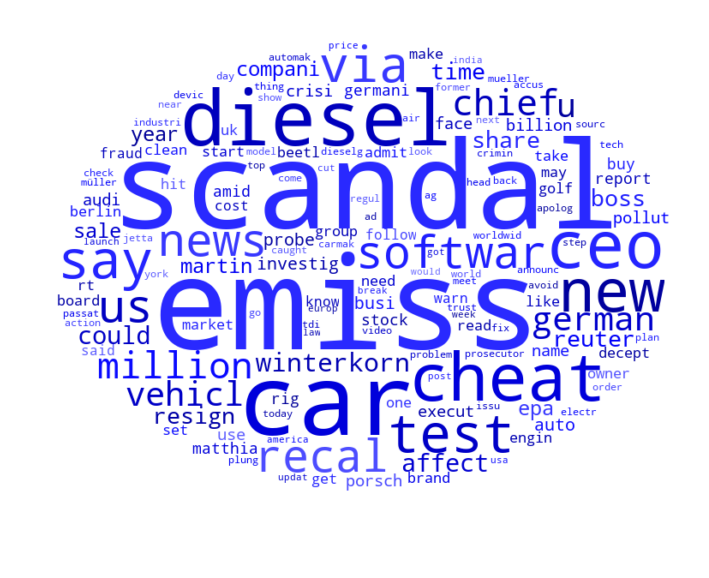

In [26]:
wc_work = wordcloud_generator(freq_dist_work, 'wordcloud_work.png', mask)

It is useful to monitor the hashtags use by Twitter users.

In [43]:
print('Original:')
print(df['text_raw'].iloc[0])
print('Transformed:')
print(' '.join(re.findall(r'#[^\s]\w+', df['text_raw'].iloc[0])))

Original:
Out here with my twin! @big_euro #socaleuro #Volkswagen #b7passat #passat #static #bagride… http://ift.tt/1JZMPmk pic.twitter.com/mVowUAs7Xv
Transformed:
#socaleuro #Volkswagen #b7passat #passat #static #bagride


In [55]:
df['hashtags'] = df['text_raw'].str.findall(r'#[^\s]\w+').apply(lambda x: ' '.join(x))

Once all hastags has been identified, we do the same steps as before. We create a long string of all hashtags in lowercase, we tokenize with a simple split. It results in **465 140** hashtags in the dataset.

In [77]:
string_data_hashtags = ' '.join([e for e in df['hashtags']]).lower()
tokens_hashtags = string_data_hashtags.split(' ')

print(f'Number of tokens : {len(tokens_hashtags):,}')

Number of tokens : 465,140


In [78]:
freq_dist_hashtags = FreqDist(tokens_hashtags)
print(f'Number of different words: {len(freq_dist_hashtags):,}')
freq_dist_hashtags

Number of different words: 23,498


FreqDist({'': 234325, '#volkswagen': 39405, '#vw': 8518, '#news': 6490, '#cars': 4343, '#business': 3525, '#tech': 2058, '#dieselgate': 1929, '#emissions': 1663, '#madeintheam': 1592, ...})

We have **23 498** different hashtags used and we can now see which one are the most commons. Of course #volkswgen is the most used.

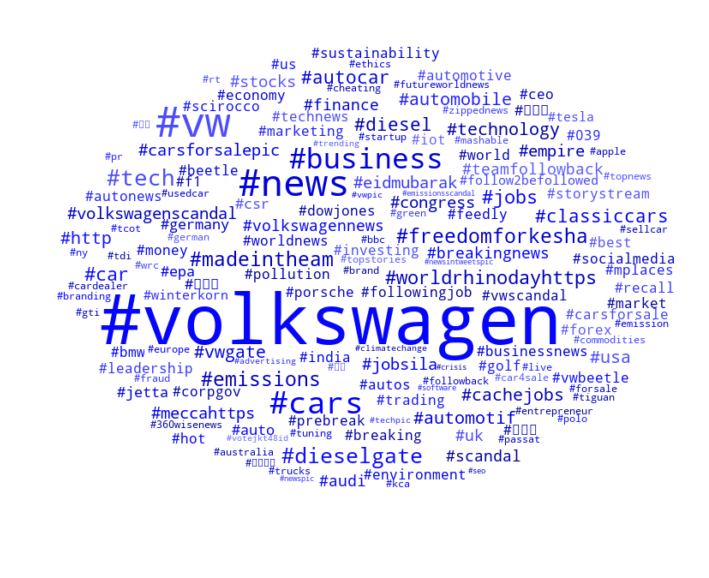

In [79]:
wc_hashtags = wordcloud_generator(freq_dist_hashtags, 'wordcloud_hashtags.png', mask)

Let's do the same for mentions.

Number of tokens : 353,850
Number of different words: 15,090
FreqDist({'': 291031, '@volkswagen': 9066, '@youtube': 1847, '@vw': 1119, '@nytimes': 1095, '@reuters': 1080, '@business': 1023, '@wsj': 743, '@mashable': 687, '@npr': 398, ...})


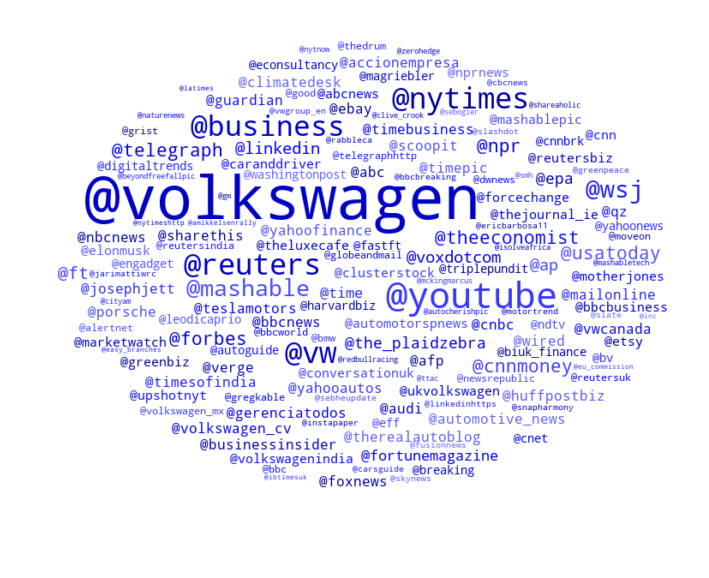

In [85]:
df['mentions'] = df['text_raw'].str.findall(r'@[^\s]\w+').apply(lambda x: ' '.join(x))

string_data_mentions = ' '.join([e for e in df['mentions']]).lower()
tokens_mentions = string_data_mentions.split(' ')

print(f'Number of tokens : {len(tokens_mentions):,}')

freq_dist_mentions = FreqDist(tokens_mentions)
print(f'Number of different words: {len(freq_dist_mentions):,}')
freq_dist_mentions.pprint()

wc_mentions = wordcloud_generator(freq_dist_mentions, 'wordcloud_mentions.png', mask)

It would be interesting to observe the evolution of the most frequent terms used during the time period we study. We will split our dataset into 7.

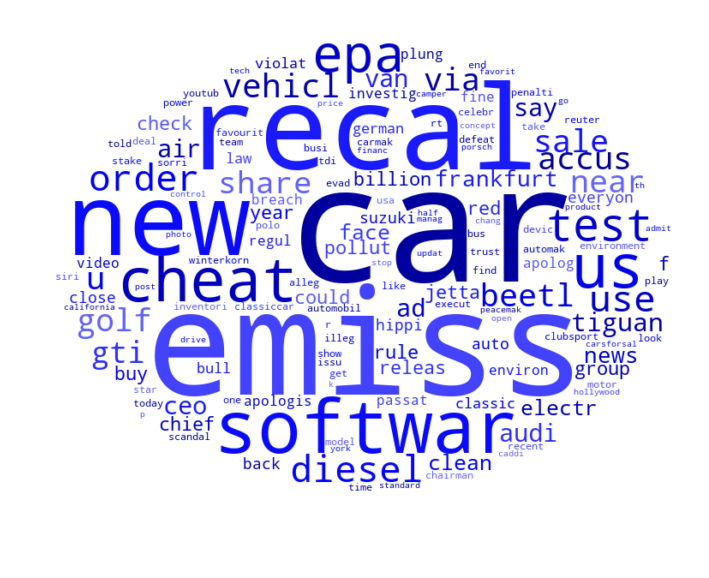

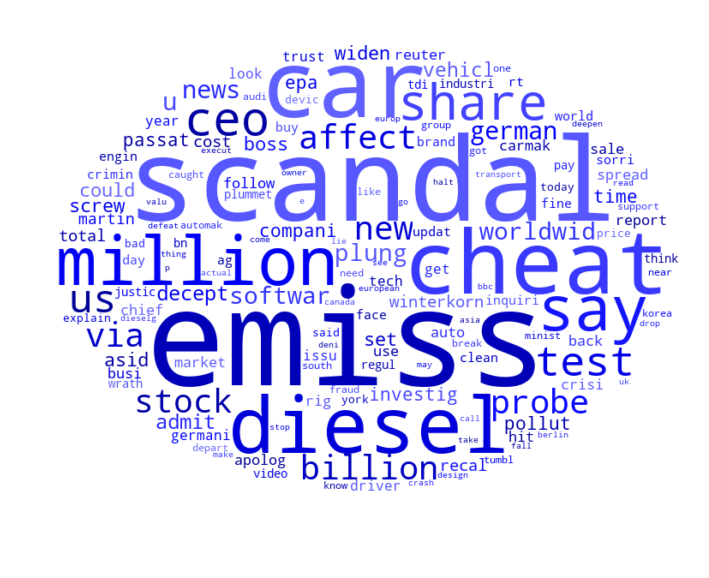

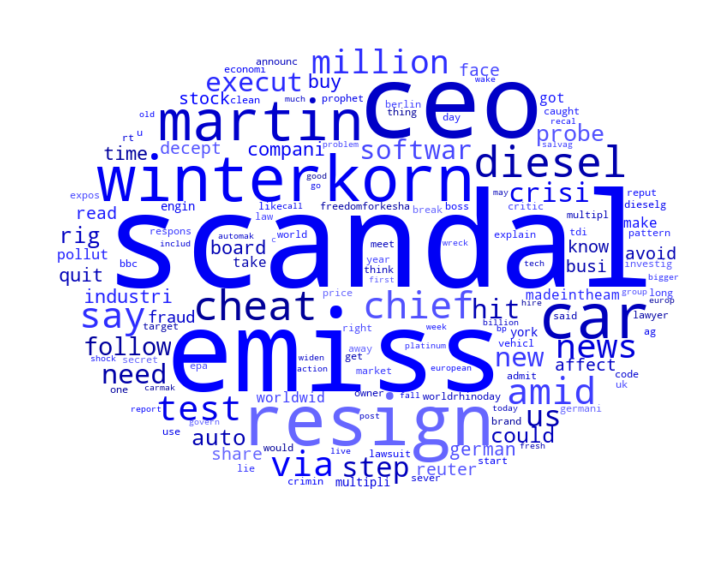

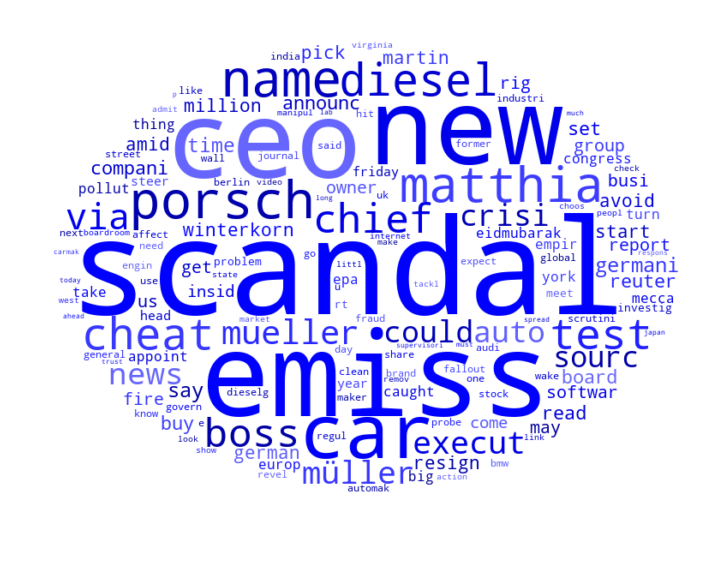

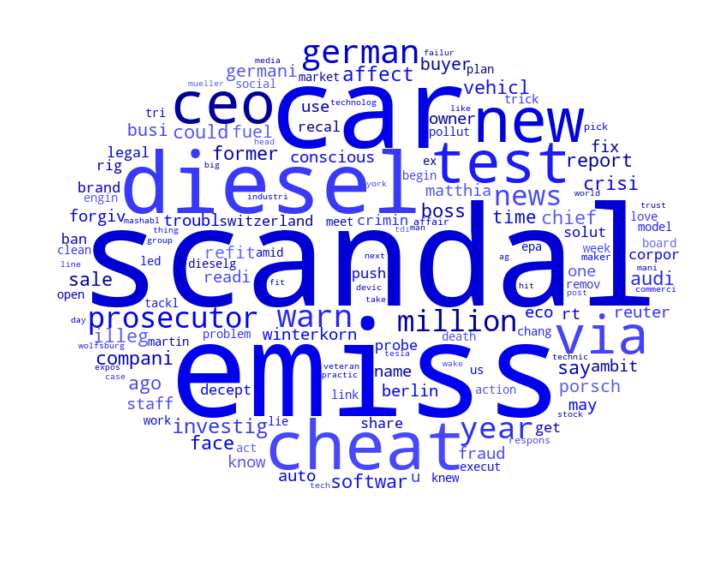

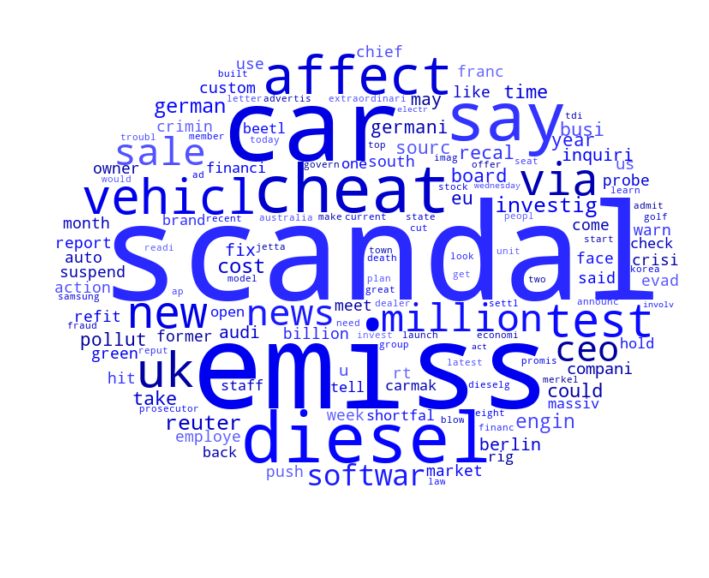

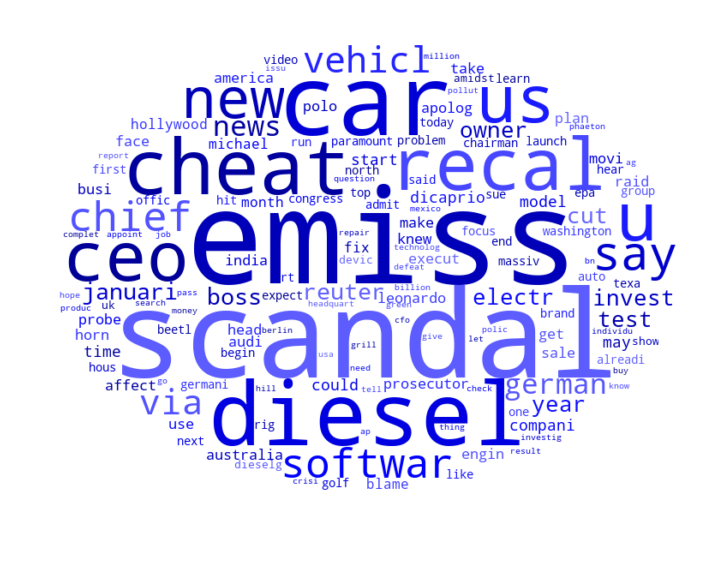

In [94]:
labels = ['text_work', 'timestamp']
splitted = df.filter(labels).sort_values(by=['timestamp'])
splits = np.split(splitted, 7)


for i in range(len(splits)):
    tmp = pd.DataFrame(splits[i], columns=labels)
    string_data_tmp = ' '.join([e for e in tmp['text_work']])
    tokens_tmp = regexp_tokenize(string_data_tmp, r'\w+')
    freq_dist_tmp = FreqDist(tokens_tmp)
    wc_tmp = wordcloud_generator(freq_dist_tmp, f'wordcloud_split_{i+1}.png', mask)

## Bigrams and Trigrams<a id='part3sec3'></a>

# Sentiment Analysis<a id='part4'></a>

# Clustering<a id='part5'></a>

# Emoji?<a id='part6'></a>